# Evaluation Metrics and Scoring

__Import libraries__

In [52]:
# essential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
import seaborn as sns
%matplotlib inline

# datasets
from sklearn.datasets import load_digits
from mglearn.datasets import make_blobs

# other tools
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# ML algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

So far, we have evaluated classification performance using accuracy (the fraction of correctly classified samples) and regression performance using R2.

---

## Keep the End Goal in Mind

- In practice, we are usually interested not just in making accurate predictions, but in using these predictions as part of a larger decision making process.
- High level goal of the application, often called the bussiness metric.
- The consequences of choosing a particular algorithm for a machine learning application are called the business impact.
- When choosing a model or adjusting parameters, you should pick the model or parameter values that have the most positive influence on the business metric.
- It pays off to find the closest metric to the original business goal that is feasible to evaluate. This closest metric should be used whenever possible for model evaluation and selection.

---

## Metrics for Binary Classification

Remember that for binary classification, we often speak of a positive class and negative class, with the understanding that the positive class is the one we are looking for.


### Kinds of errors

- Often, accuracy is not a good measure of predictive performance.
- Problems of true positive, true negative, false positive and false negative.
- In statistics, a false positive is also known as type I error, and a false negative as type II error.
- Good example is about cancer patient.

### Imbalanced datasets

- Imbalanced datasets: where one class is much more frequent than the other

In [2]:
digits = load_digits()
y = digits.target == 9

In [4]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

We can use the DummyClassifier to always predict the majority class (here
“not nine”) to see how uninformative accuracy can be:

In [5]:
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: [False]
Test score: 0.90


We obtained close to 90% accuracy without learning anything. This might seem striking,
but think about it for a minute. Imagine someone telling you their model is 90%
accurate. You might think they did a very good job. But depending on the problem,
that might be possible by just predicting one class! Let’s compare this against using an
actual classifier:

In [13]:
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Test score: {:.2f}".format(tree.score(X_test, y_test)))

Test score: 0.92


According to accuracy, the DecisionTreeClassifier is only slightly better than the
constant predictor. This could indicate either that something is wrong with how we
used DecisionTreeClassifier, or that accuracy is in fact not a good measure here.

For comparison purposes, let’s evaluate two more classifiers, LogisticRegression
and the default DummyClassifier, which makes random predictions but produces
classes with the same proportions as in the training set:

In [14]:
dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

dummy score: 0.84


C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


logreg score: 0.98


The problem here is that accuracy is an inadequate measure for quantifying predictive performance in this imbalanced setting. For the rest of this chapter, we will explore alternative metrics that provide better guidance in selecting models. In particular, we would like to have metrics that tell us how much better a model is than making “most frequent” predictions or random predictions, as they are computed in pred_most_frequent and pred_dummy. If we use a metric to assess our models, it should definitely be able to weed out these nonsense predictions.

### Confusion matrices

One of the most comprehensive waysto represent the result of evaluating binary classification is using confusion matrices.

In [7]:
confusion = confusion_matrix(y_test, pred_logreg)

In [8]:
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[401   2]
 [  8  39]]


The output of confusion_matrix is a two-by-two array, where the rows correspond
to the true classes and the columns correspond to the predicted classes. Each entry
counts how often a sample that belongs to the class corresponding to the row (here,
“not nine” and “nine”) was classified as the class corresponding to the column.

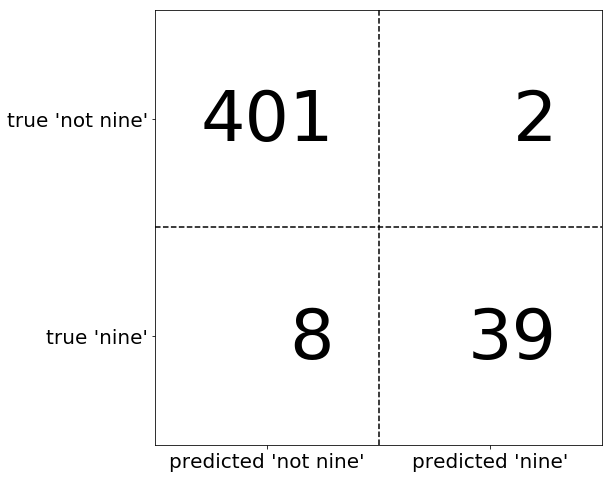

In [16]:
mglearn.plots.plot_confusion_matrix_illustration()

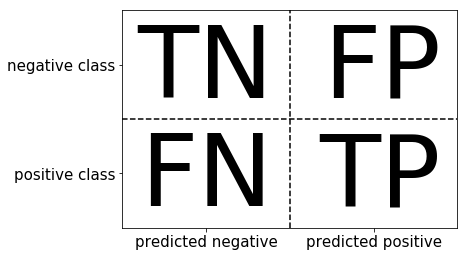

In [17]:
mglearn.plots.plot_binary_confusion_matrix()

In [18]:
print("Most frequent class:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\nDummy model:")
print(confusion_matrix(y_test, pred_dummy))
print("\nDecision tree:")
print(confusion_matrix(y_test, pred_tree))
print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[357  46]
 [ 40   7]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression
[[401   2]
 [  8  39]]


In [11]:
print(403/450)
print((357+7)/450)
print((390+23)/450)
print((401+39)/450)

0.8955555555555555
0.8088888888888889
0.9177777777777778
0.9777777777777777


### Relation to accuracy

$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

### Precision, recall, and f-score

- Ways to summarize the confusion matrix: precision and recall.

Precision measures how many of the samples predicted as positive are actually positive.

$Precision = \frac{TP}{TP + FP}$

- Precision is used as a performance metric when the goal is to limit the number of false positives.
- As an example, imagine a model for predicting whether a new drug will be effective in treating a disease in clinical trials. Clinical trials are notoriously expensive, and a pharmaceutical company will only want to run an experiment if it is very sure that the drug will actually work. Therefore, it is important that the model does not produce many false positives—in other words, that it has a high precision. Precision is also known as positive predictive value (PPV).

Recall measures how many of the positive samples are captured by the positive predictions:

$Recall = \frac{TP}{TP + FN}$

Recall is used as performance metric when we need to identify all positive samples;
that is, when it is important to avoid false negatives. The cancer diagnosis example
from earlier in this chapter is a good example for this: it is important to find all people
that are sick, possibly including healthy patients in the prediction. Other names
for recall are sensitivity, hit rate, or true positive rate (TPR).

There is a trade-off between optimizing recall and optimizing precision. You can trivially
obtain a perfect recall if you predict all samples to belong to the positive class—
there will be no false negatives, and no true negatives either. However, predicting all
samples as positive will result in many false positives, and therefore the precision will
be very low. On the other hand, if you find a model that predicts only the single data
point it is most sure about as positive and the rest as negative, then precision will be
perfect (assuming this data point is in fact positive), but recall will be very bad.

f-score or f-measure, which is with the harmonic mean of precision and recall:

$F = 2 \times \frac{precision\hspace{2pt}\times\hspace{2pt}recall}{precision\hspace{2pt}+\hspace{2pt}recall}$

This particular variant is also known as the $f_{1}$-score. As it takes precision and recall into account, it can be a better measure than accuracy on imbalanced binary classification datasets.

In [16]:
print("f1 score most frequent: {:.3f}".format(f1_score(y_test, pred_most_frequent)))
print("f1 score dummy: {:.3f}".format(f1_score(y_test, pred_dummy)))
print("f1 score tree: {:.3f}".format(f1_score(y_test, pred_tree)))
print("f1 score logreg: {:.3f}".format(f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.000
f1 score dummy: 0.098
f1 score tree: 0.554
f1 score logreg: 0.886


C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Using the f-score for evaluation, we summarized the predictive performance
again in one number. However, the f-score seems to capture our intuition
of what makes a good model much better than accuracy did. A disadvantage of the
f-score, however, is that it is harder to interpret and explain than accuracy.

If we want a more comprehensive summary of precision, recall, and f1-score, we can
use the classification_report convenience function to compute all three at once,
and print them in a nice format:

In [19]:
print(classification_report(y_test, pred_most_frequent, target_names=['not nine', 'nine']))

              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

   micro avg       0.90      0.90      0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The classification_report function produces one line per class (here, True and
False) and reports precision, recall, and f-score with this class as the positive class.
Before, we assumed the minority “nine” class was the positive class. If we change the
positive class to “not nine,” we can see from the output of classification_report
that we obtain an f-score of 0.94 with the most_frequent model. Furthermore, for the
“not nine” class we have a recall of 1, as we classified all samples as “not nine.” The
last column next to the f-score provides the support of each class, which simply means
the number of samples in this class according to the ground truth.

In [27]:
print(classification_report(y_test, pred_dummy, target_names=['not nine', 'nine']))

              precision    recall  f1-score   support

    not nine       0.90      0.89      0.89       403
        nine       0.13      0.15      0.14        47

   micro avg       0.81      0.81      0.81       450
   macro avg       0.52      0.52      0.52       450
weighted avg       0.82      0.81      0.81       450



In [23]:
confusion_matrix(y_test, pred_logreg)

array([[401,   2],
       [  8,  39]], dtype=int64)

In [27]:
print(39/(39+2))
print(39/(39+8))
print(401/(401+8))
print(401/(401+2))

0.9512195121951219
0.8297872340425532
0.980440097799511
0.9950372208436724


In [28]:
print(classification_report(y_test, pred_logreg, target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.98      1.00      0.99       403
        nine       0.95      0.83      0.89        47

   micro avg       0.98      0.98      0.98       450
   macro avg       0.97      0.91      0.94       450
weighted avg       0.98      0.98      0.98       450



### Taking uncertainty into account

- Recall: most classifiers provide a decision_function or a predict_proba method to assess degrees of certainty about predictions.

In [29]:
X, y = make_blobs(n_samples=(400, 50), centers=2, cluster_std=[7.0, 2], random_state=22)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=0.05).fit(X_train, y_train)

C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=DeprecationWarning)


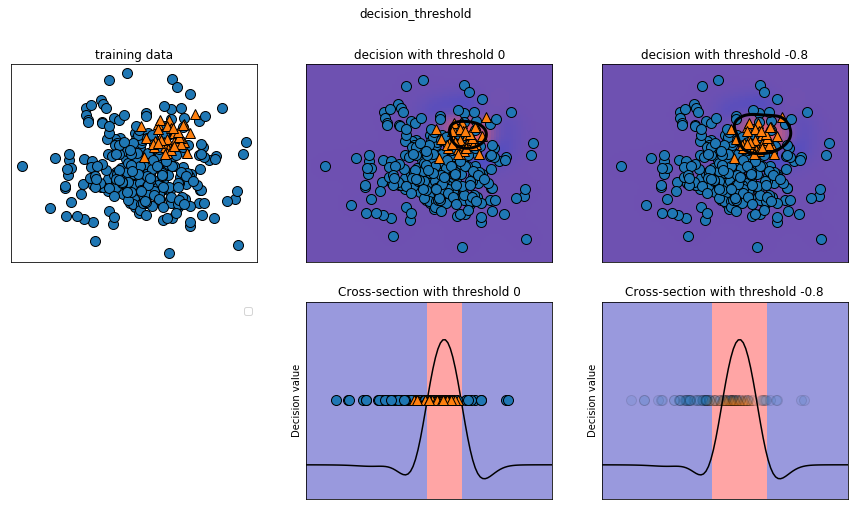

In [34]:
mglearn.plots.plot_decision_threshold()

In [35]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

   micro avg       0.88      0.88      0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



For class 1, we get a fairly small precision, and recall is mixed. Because class 0 is so much larger, the classifier focuses on getting class 0 right, and not the smaller class 1.

Let’s assume in our application it is more important to have a high recall for class 1, as
in the cancer screening example earlier. This means we are willing to risk more false
positives (false class 1) in exchange for more true positives (which will increase the
recall). The predictions generated by svc.predict really do not fulfill this requirement,
but we can adjust the predictions to focus on a higher recall of class 1 by
changing the decision threshold away from 0. By default, points with a deci
sion_function value greater than 0 will be classified as class 1. We want more points
to be classified as class 1, so we need to decrease the threshold:

In [38]:
svc.decision_function(X_test)

array([-0.99973208, -1.00148617, -1.1386043 , -0.98505482, -1.01044247,
       -1.00027441, -1.00609413,  0.88395198, -1.00467053, -1.00283866,
       -1.00097712,  1.07030762, -1.02076344, -0.40435353, -0.48739733,
       -1.00121046, -1.09560781, -1.44572917, -0.99908802, -1.00070245,
       -0.44364565, -1.01170286, -0.99918954, -1.0861769 , -1.33291363,
       -1.00320657, -0.99076097, -1.09564958,  0.63212214, -0.99238394,
       -1.47090403,  0.19153373,  0.74430046, -1.0084656 , -1.15104651,
       -1.02852903, -1.00840776, -1.23180696, -1.0031964 , -1.00023926,
       -1.0013854 , -1.00003771, -1.10114776, -0.98779744, -1.05818617,
       -1.00105363,  0.5230006 ,  0.97789353, -0.99559099,  0.52008479,
       -1.25711078, -1.08267667, -0.99828696, -1.00385465,  0.08620484,
       -0.99871026, -1.06221884, -1.02415268, -1.08797969, -1.06010122,
        0.36988055, -1.05630237, -0.99981001, -0.24173165, -1.02857919,
       -1.00058106, -0.99968788, -1.00115386, -0.99882791,  1.25

In [39]:
y_pred_lower_threshold = svc.decision_function(X_test) > -0.8

In [40]:
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

   micro avg       0.83      0.83      0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



If you value precision over recall or the other way around, or your data is
heavily imbalanced, changing the decision threshold is the easiest way to obtain better
results. As the decision_function can have arbitrary ranges, it is hard to provide
a rule of thumb regarding how to pick a threshold.

### Precision-recall curves and ROC curves

Setting a requirement on a classifier like 90% recall is often called setting the operating
point. Fixing an operating point is often helpful in business settings to make performance
guarantees to customers or other groups inside your organization.

Often, when developing a new model, it is not entirely clear what the operating point
will be. For this reason, and to understand a modeling problem better, it is instructive
to look at all possible thresholds, or all possible trade-offs of precision and recalls at
once. This is possible using a tool called the precision-recall curve.

In [30]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

In [32]:
print(precision.shape)
print(recall.shape)
print(thresholds.shape)

(29,)
(29,)
(28,)


In [33]:
thresholds

array([-0.7512563 , -0.58749402, -0.48739733, -0.44364565, -0.40435353,
       -0.28965335, -0.24173165, -0.19257469, -0.17852475, -0.16644845,
       -0.1601932 ,  0.08620484,  0.14630375,  0.19153373,  0.36988055,
        0.52008479,  0.5230006 ,  0.53195462,  0.63212214,  0.74430046,
        0.87212596,  0.88002558,  0.88395198,  0.97789353,  1.00010384,
        1.07030762,  1.08436417,  1.25059991])

C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=DeprecationWarning)


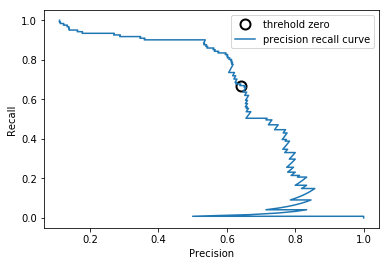

In [36]:
# Use more data points for a smoother curve
X, y = make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2],
                 random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=0.05).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
        label='threhold zero', fillstyle='none', c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

We can see, for example, that we can achieve a recall of 0.4 at a
precision of about 0.75. The black circle marks the point that corresponds to a threshold
of 0, the default threshold for decision_function. This point is the trade-off
that is chosen when calling the predict method.


The closer a curve stays to the upper-right corner, the better the classifier. A point at
the upper right means high precision and high recall for the same threshold. The
curve starts at the top-left corner, corresponding to a very low threshold, classifying
everything as the positive class. Raising the threshold moves the curve toward higher
precision, but also lower recall. Raising the threshold more and more, we get to a situation
where most of the points classified as being positive are true positives, leading
to a very high precision but lower recall. The more the model keeps recall high as
precision goes up, the better.

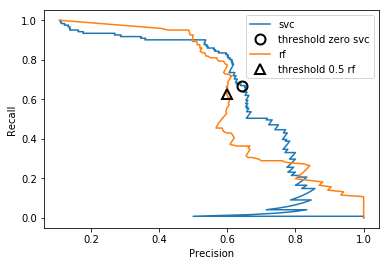

In [39]:
rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# RandomForestClassifier has predict_proba, but not decision_function
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label='svc')

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
label="threshold zero svc", fillstyle="none", c='k', mew=2)

plt.plot(precision_rf, recall_rf, label="rf")
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
            markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

In [41]:
print("f1_score of random forest: {:.3f}".format(
f1_score(y_test, rf.predict(X_test))))
print("f1_score of svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

f1_score of random forest: 0.610
f1_score of svc: 0.656


In [42]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print("Average precision of random forest: {:.3f}".format(ap_rf))
print("Average precision of svc: {:.3f}".format(ap_svc))

Average precision of random forest: 0.660
Average precision of svc: 0.666


### Reciever operating characteristics (ROC) and AUC

Similar to the precision-recall curve, the ROC curve considers all possible
thresholds for a given classifier, but instead of reporting precision and recall, it shows
the false positive rate (FPR) against the true positive rate (TPR). Recall that the true
positive rate is simply another name for recall, while the false positive rate is the fraction
of false positives out of all negative samples:

$FPR = \frac{FP}{FP+TN}$

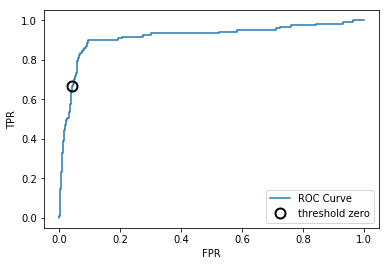

In [43]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

For the ROC curve, the ideal curve is close to the top left: you want a classifier that
produces a high recall while keeping a low false positive rate. Compared to the default
threshold of 0, the curve shows that we can achieve a significantly higher recall
(around 0.9) while only increasing the FPR slightly. The point closest to the top left
might be a better operating point than the one chosen by default. Again, be aware that
choosing a threshold should not be done on the test set, but on a separate validation
set.

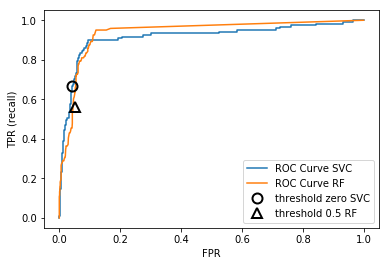

In [44]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
            label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10,
            label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)

In [45]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.937
AUC for SVC: 0.916


Comparing the random forest and SVM using the AUC score, we find that the random
forest performs quite a bit better than the SVM. Recall that because AUC is the
area under a curve that goes from 0 to 1, AUC always returns a value between 0
(worst) and 1 (best). Predicting randomly always produces an AUC of 0.5, no matter
how imbalanced the classes in a dataset are. This makes AUC a much better metric
for imbalanced classification problems than accuracy. The AUC can be interpreted as
evaluating the ranking of positive samples. It’s equivalent to the probability that a randomly
picked point of the positive class will have a higher score according to the classifier
than a randomly picked point from the negative class. So, a perfect AUC of 1
means that all positive points have a higher score than all negative points. For classification
problems with imbalanced classes, using AUC for model selection is often
much more meaningful than using accuracy.

gamma = 1.00 accuracy = 0.90 AUC = 0.50
gamma = 0.05 accuracy = 0.90 AUC = 1.00
gamma = 0.01 accuracy = 0.90 AUC = 1.00


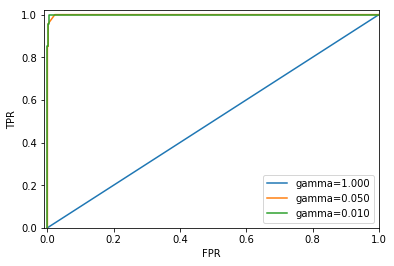

In [46]:
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
digits.data, y, random_state=0)

plt.figure()

for gamma in [1, 0.05, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
    print("gamma = {:.2f} accuracy = {:.2f} AUC = {:.2f}".format(
    gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

---

## Metrics for Multiclass Classification

In [47]:
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))

C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


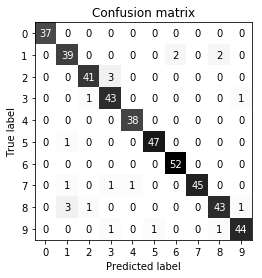

In [49]:
scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, pred), xlabel='Predicted label',
                                        ylabel='True label', xticklabels=digits.target_names,
                                        yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [50]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

   micro avg       0.95      0.95      0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



The most commonly used metric for imbalanced datasets in the multiclass setting is the multiclass version of the f-score. The idea behind the multiclass f-score is to compute one binary f-score per class, with that class being the positive class and the other classes making up the negative classes. Then, these per-class f-scores are averaged using one of the following strategies:
- "macro" averaging computes the unweighted per-class f-scores. This gives equal weight to all classes, no matter what their size is.
- "weighted" averaging computes the mean of the per-class f-scores, weighted by their support. This is what is reported in the classification report.
- "micro" averaging computes the total number of false positives, false negatives, and true positives over all classes, and then computes precision, recall, and fscore using these counts.

If you care about each sample equally much, it is recommended to use the "micro" average f1-score; if you care about each class equally much, it is recommended to use the "macro" average f1-score

---

## Regression Metrics

R2 is quite enough for most cases.

---

## Using Evaluation Metrics in Model Selection

In [53]:
from sklearn.model_selection import cross_val_score
# default scoring for classification is accuracy
print("Default scoring: {}".format(cross_val_score(SVC(), digits.data, digits.target == 9)))
# providing scoring="accuracy" doesn't change the results
explicit_accuracy = cross_val_score(SVC(), digits.data, digits.target == 9,
                                    scoring="accuracy")
print("Explicit accuracy scoring: {}".format(explicit_accuracy))
roc_auc = cross_val_score(SVC(), digits.data, digits.target == 9,
                            scoring="roc_auc")
print("AUC scoring: {}".format(roc_auc))

Default scoring: [0.89983306 0.89983306 0.89983306]
Explicit accuracy scoring: [0.89983306 0.89983306 0.89983306]
AUC scoring: [0.99372294 0.98957947 0.99594929]


In [55]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
                digits.data, digits.target == 9, random_state=0)

# we provide a somewhat bad grid to illustrate the point:
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}

# using the default scoring of accuracy:
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (accuracy)): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy)): 0.970
Test set AUC: 0.992
Test set accuracy: 0.973


In [56]:
# using AUC scoring instead:
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train)
print("\nGrid-Search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))


Grid-Search with AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.997
Test set AUC: 1.000
Test set accuracy: 1.000


The most important values for the scoring parameter for classification are accuracy
(the default); roc_auc for the area under the ROC curve; average_precision for the
area under the precision-recall curve; f1, f1_macro, f1_micro, and f1_weighted for
the binary f1-score and the different weighted variants. For regression, the most commonly
used values are r2 for the R2 score, mean_squared_error for mean squared
error, and mean_absolute_error for mean absolute error. You can find a full list of
supported arguments in the documentation or by looking at the SCORER dictionary
defined in the metrics.scorer module:

In [57]:
from sklearn.metrics.scorer import SCORERS
print("Available scorers:\n{}".format(sorted(SCORERS.keys())))

Available scorers:
['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'brier_score_loss', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']
